# Ⅰ. 주요 개념

# 1. seq2seq

#### [1] NNLM의 한계 : 유연성 한계(고정된 크기)
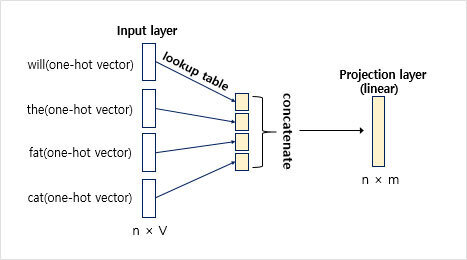
   
   
#### [2] RNN : 순차적 적립 방식
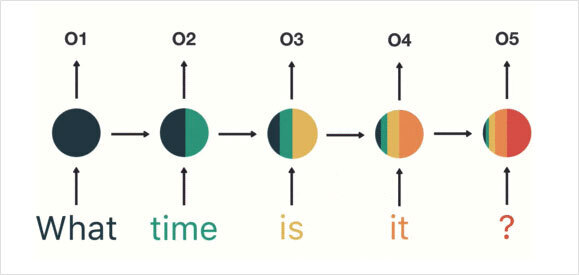
  
   
#### [3] RNN의 한계 
① 기울기 소실(vanishing gradient)
- LSTM 사용 제안( Vanilla RNN은 긴 입력에 대한 정보를 학습시키기 어렵다)
  
② 번역에 사용하기 어렵다.(언어마다 어순이 다름)
p(y1,...,yT′|x1,...,xT) = ΠT′t=1p(yt|v,y1,...,yt−1)
x: Input Sequence
y: Output Sequence
v: 인코더의 입력 x에 대한 고정된 크기의 Representation Vector 아웃풋
  
  
#### [4] 입력과 출력의 "establish communication"
- 입력 abc와 출력 def에 대해 a->d, b->e, c->f의 관계를 가진다면 입력을 cba로 뒤집어 관련 있는 단어끼리 같은 거리를 갖게 한다. 이 단순한 변형은 SGD가 입출력 간의 구조적 관계를 파악하는 것을 용이하게 하고 LSTM에 대해 성능을 Boost하는 효과가 있다.
   
   
#### [5] Sequence-to-Sequence
- Encoder은 입력 문장의 모든 단어들을 순차적으로 입력받고 모든 단어를 압축한 단 하나의 컨텍스트 벡터(context vector)를 만듬
- 문장의 시작과 끝에 토큰 부여 : 시작 토큰이 없는 경우, Decoder의 첫 입력으로 전달할 단어가 없어져 번역을 진행할 수 없다. 만일 랜덤한 단어를 입력할 경우, 번역의 성능에 문제가 생긴다. 끝 토큰이 없는 경우, 문장의 끝을 알릴 수 없어 단어를 무한정 생성하게 된다. 
- 어텐션 메커니즘 도입 : 문맥을 더 잘 반영하는 벡터 생성
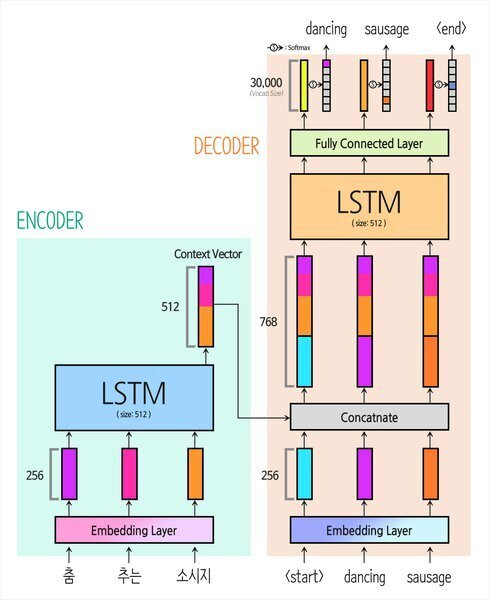


# 2. Bahdanau Attention

#### [1] 문제제기와 해결방안
- 문제 : Seq2Seq의 컨텍스트 벡터가 고정된 길이로 정보를 압축하는 것이 손실을 야기한다
- 해법 : Encoder의 최종 State 값만을 사용하는 기존의 방식이 아닌, 매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축하는 Attention 메커니즘
  
#### [2] Attention 메카니즘
- 모델 성능향상
- Attention Map의 시각화를 통해 모델의 안정성을 점검할 수 있고, 모델이 의도와 다르게 작동될 경우 그 원인을 찾아내는 데에 이용될 수 있다.
- 작업(task) : Sequence Labeling, Sequence to Sequence    
① 예시 : Sequence Labeling(품사 태깅), Sequence to Sequence(번역)   
② 차이점 : Sequence Labeling( xi 와 yi의 관계를 구하는 문제)    
     Sequence to Sequence( x1:n 과 동일한 의미를 가지는 y1:m 을 만드는 문제)

#### [3] seq2seq과 attn-seq2seq, 뭐가 다른가?
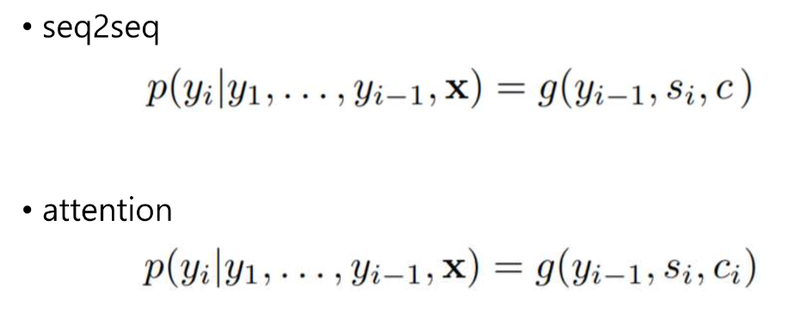
- 첨자 하나가 어떤 근본적인 차이
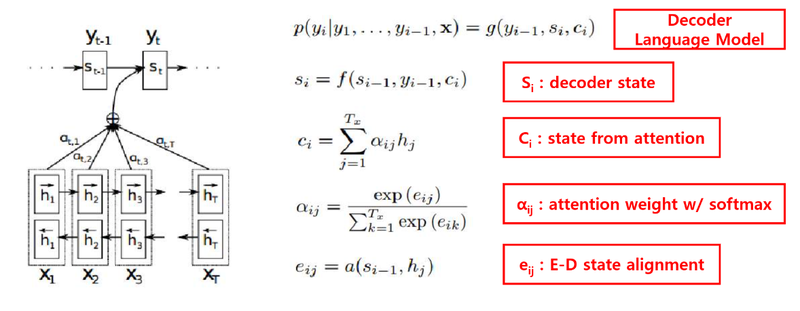
- i는 디코더의 인덱스, j는 인코더의 인덱스
- context vector c에 첨자 i가 붙어 ci가 된다는 것의 의미 : 인코더가 X를 해석한 context ci는 디코더의 포지션 i에 따라 다르게 표현(represent)되어야 한다.
- 디코더가 현재 시점 i에서 보기에 인코더의 어느 부분 j가 중요한가? 이 가중치가 바로 attention인 것
- αij가 바로 인코더의 j번째 hidden state hj가 얼마나 강조되어야 할지를 결정하는 가중치 역할
- 가중치αij는 다시 디코더의 직전 스텝의 hidden state s(i−1)와 hj의 유사도가 높을수록 높아지게 됨.
- αij합은 1 : softmax함수에 기인함.

#### [4] 실제 작용
- 역전파(Backpropagation). 역전파는 output이 정답에 가까워지도록 보장하는 데 필요한 모든 작업을 수행합니다. 이는 RNN과 스코어 함수가 있는 경우 해당 스코어 함수에서 가중치를 변경하여 수행됩니다. 이러한 가중치는 인코더 hidden state 및 디코더 hidden state에 영향을 미치고 attention 점수에 영향을 미칩니다.

# Ⅱ. 프로세스와 주요 함수/클래스

# 1. 프로세스 개요

## (1) Bahdanau Attention 절차

### 0단계 : 
- hidden state의 준비  

### 1단계 : 
- 모든 인코더 hidden state의 점수 얻기   
  ※ 특정 벡터 공간으로 맵핑된 두 Hidden State의 합  

### 2단계 : 
- 모든 점수를 softmax 레이어를 통해 실행  
  ※ Softmax의 결괏값은 Encoder에 매 스텝마다 입력으로 들어온 각 단어의 비중이 서로 영향을 줌  
  ※ RNN은 단어의 정보를 순차적으로 적립하여 Hidden State를 구축하기 때문에   
     순방향 RNN의 첫 단어는 그 단어의 정보만을 담았을지언정  
     그 이후 스텝들은 거쳐온 모든 단어의 정보를 포함하고 있다.  

### 3단계 : 
- 얼라인먼트 값 산출(각 인코더 hidden state에 softmaxed 점수를 곱함)  

### 4단계 : 
- 컨텍스트 벡터 산출(얼라이먼트 벡터를 합)  
  ※ 컨텍스트 벡터가 핵심 단어(비중이 큰 단어)에 가장 근접하게 다가서되,   
     주변 단어에도 각각의 비중만큼 영향을 받아 문장을 적합한 위치에 매핑되게 한다.  
  ※ 기존 RNN의 최종 스텝을 컨텍스트 벡터로 쓰던 방식은  
     항상 고정된 비중을 사용(마지막에 등장한 단어가 큰 비중)하는 셈이므로  
     Bahdanau의 방식보다 문맥 정보를 유연하게 반영하지 못한다.  

### 5단계 : 
- context 벡터를 디코더에 전달  
  ※ Decoder의 이전 Hidden State와 Concatenate하여 새로운 Hidden State로 정의된다.

## (2) translation

### [1] 손실함수
- fit()을 사용하지 않고 클래스 구조로 만드는 이유
  => Encoder-Decoder 구조 : 특수한 구조로 직접 Loss를 커스텀해서 사용
- SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구줌
   * CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 거죠.
   
- from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정합니다.
    * 우리는 True 로 줬으니 모델의 출력값을 그대로 전달하면 됩니다!
- 데이터를 한 번에 처리하기 위해 가장 긴 문장을 기준으로 패딩(Padding) 과정을 거침
    * tokenize() 함수 내부의 pad_sequences() 가 바로 그 역할을 함.

- 만약 모델에게 \<PAD> 토큰이 패딩을 위한 토큰이라고 명시하지 않으면 모델은 데이터의 굉장히 많은 부분이 \<PAD> 로 이뤄져 있다고 생각하게 됩니다.

     * 모델은 심지어 10,000개의 정답이 넘게 있는 고난도의 문제를 풀고 있기 때문에 패딩에 대한 처리를 해주지 않으면 \<PAD> 토큰만을 생성할 확률이 굉장히 높아집니다.
     => 이 문제를 방지하기 위해 mask 가 사용됩니다! mask 는 정답지에서 \<PAD> 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 한다. equal() 함수에 정확히는 0이 아닌 \<PAD> 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리하도록 하겠습니다.

### [2] train_step 구현하기
- train_step() : 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수
  
- @tf.function 데코레이터 : 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와준다.
   * 첫 번째 Epoch이 다른 Epoch보다 약간의 시간이 더 걸리는 것은
      데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문이다.
  
- tf.GradientTape() : 학습하며 발생한 모든 연산을 기록하는 테이프이다.
    * 이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됨
  
- train_step()의 학습 과정
① Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
② t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
③ Decoder에 입력으로 전달할 \<start> 토큰 문장 생성
④ \<start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
⑤ 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
    * 반복!

### [3] 훈련
- 훈련 과정
① EPOCHS = 10 만큼 반복하는 루프에 진입
② 각 배치의 시작 인덱스를 idx_list 배열에 저장   
③ 모델이 학습을 원활하게 할 수 있도록 데이터를 섞어줘야 하는데요, 인덱스를 섞어서 처리함.(랜덤한 인덱스)   
④ 각 미니배치를 train_step() 함수에서 학습함.   
     * train_step()은 학습에 필요한 것은 모두 가져와 Loss를 계산한 후 반환하는 함수


### [4] 번역 실습
- 데이터 전처리과정에서 분리한 Validation Set을 사용하는 eval_step() 함수를 정의
- 그리고 train_step() 을 마친 후, 곧이어 eval_step() 을 진행

## (3) 데이터 전처리 및 시각화

## (4) 모델링

## (5) 학습설계

## (6) 학습과 성과측정

# 2. 패키지의 함수/클래스 개요

## (1) tf.keras.layers

### Layer
- 상태(레이어의 가중치)와 입력값을 받아 캡슐화 변환(호출, 레이어의 정방향 패스)을 통해 출력값 반환

### Embedding
- 주로 자연어 처리에서 사용됨.
- 자연어를 수치화된 정보로 변환하기 위한 레이어
- 숫자를 입력 받아 output 차원 크기의 dense vector(sparse vector와 반대 개념)를 만듬
- 인자
   * input_dim : 들어가는 숫자의 최댓값
   * output_dim : 결과값 차원

### GRU
- RNN계열의 모델, LSTM과 비슷한 역할. 더 간단한 구조/효율적인 계산

## (2) tqdm.tqdm
- for 문이 얼마나 실행 과정을 한눈에 볼 수 있게 해주는 라이브러리

### tqdm()

### set_description_str(desc=None, refresh=True) : 
Set/modify description without ': ' appended.

### set_postfix_str(s='', refresh=True) : 
Postfix without dictionary expansion, similar to prefix handling.

# Ⅲ. 프로젝트 : 한영 번역기 만들기

# Step 1. 데이터 다운로드
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.   
https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

# 1. 준비사항

In [ ]:
$ mkdir -p ~/aiffel/s2s_translation
$ sudo apt -qq -y install fonts-nanum
# mecab 설치
$ sudo apt-get install curl git
$ bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import time
import re
import os
import io

from tqdm import tqdm    # tqdm
import random

from konlpy.tag import Mecab

print(tf.__version__)

2.4.1


In [2]:
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [3]:
# GPU out of memory 문제로 코드 추가
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# import tensorflow as tf
# gpus = tf.config.list_physical_devices('GPU')
# gpu = gpus[0]

# tf.config.experimental.set_memory_growth(gpu, True)

# 2. 데이터 전처리

## (1) 데이터 준비하기

In [4]:
# 디렉토리 경로 설정
train_folder_path = os.getenv('HOME') + '/aiffel/NLP/08_s2s_translation/data/'
test_folder_path = os.getenv('HOME') + '/aiffel/NLP/08_s2s_translation/data/'

# 파일 경로 설정
train_ko_data_path = train_folder_path + 'korean-english-park.train.ko'
train_en_data_path = train_folder_path + 'korean-english-park.train.en'

In [5]:
# 파일 읽기
with open(train_ko_data_path, 'r') as f:
    train_ko_data = f.read().splitlines()
    
with open(train_en_data_path, 'r') as f:
    train_en_data = f.read().splitlines()
    
# 파일 크기 확인
print('train_ko_data size : ', len(train_ko_data))
print('train_en_data size : ', len(train_en_data))

train_ko_data size :  94123
train_en_data size :  94123


In [6]:
for i in range(0,100,20):
    print('>> ', train_ko_data[i])
    print('>> ', train_en_data[i], '\n')

>>  개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>>  Much of personal computing is about "can you top this?" 

>>  북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>>  Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations. 

>>  "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>>  “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said. 

>>  수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>>  Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project. 

>>  또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
>>  Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of work

## (2) 데이터 전처리 : 정제하기
1) set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2) 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3) 타겟 언어인 영문엔 \<start> 토큰과 \<end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

### 중복 데이터 제거

In [7]:
cleaned_corpus = list(set(zip(train_ko_data, train_en_data)))

print(f'중복 데이터 제거후 데이터 크기 : {len(cleaned_corpus)}\n') 
print(f'[ 샘플 데이터 ]\n {cleaned_corpus[0]}') 

중복 데이터 제거후 데이터 크기 : 78968

[ 샘플 데이터 ]
 ('록 오페라 제작자이자 예술단체인 캄보디아의 현존한 예술(Cambodian Living Arts)을 창립한 명예회장인 존 버트는 “문화가 전쟁의 비극에 의해 중단되면 특별히 전통으로 돌아가는 것이 중요하다고 생각하지만 우리는 21세기를 살고 있고 앞으로의 전통을 세워나가는 것도 중요하다고 생각한다”고 밝혔다.', '"I think when any culture is interrupted by the tragedy of war, it\'s particularly important to go back and visit those (ancient) traditions, but we are in the 21st century and it\'s also important to bring those traditions forward," said John Burt, the show\'s executive producer and founding chair emeritus of Cambodian Living Arts, which commissioned the production.')


### 한글/영자 문서 정제

In [8]:
# 한글문서 정제
def preprocess_sentence_ko(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    # 형태소 토큰
    mecab = Mecab()
    sentence = mecab.morphs(sentence)

    return sentence

In [9]:
# 영어문서 정제 
def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    # 영문(타겟언어) : 시작토큰, 끝토큰 추가
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


### 토큰 길이 제한(40 이하 데이터)

In [11]:
kor_corpus = []
eng_corpus = []

for x in cleaned_corpus:
    ko = preprocess_sentence_ko(x[0])
    en = preprocess_sentence_en(x[1], s_token=True, e_token=True)
#     kor_corpus.append(ko)
#     eng_corpus.append(en)
    
    # 토큰 40 이하 데이터 조건 적용
    if len(ko) <= 40 and len(en) <= 40:
        kor_corpus.append(ko)
        eng_corpus.append(en)


print(len(kor_corpus), len(eng_corpus))

print('\n한글문장>> ', kor_corpus[0])
print('\n영어문장>> ', eng_corpus[0])

796 796

한글문장>>  ['네', '팔', '신', '정부', '가', '국왕', '이', '떠난', '화려', '한', '왕궁', '을', '박물관', '으로', '개조', '했', '다', '.']

영어문장>>  <start> kathmandu , nepal cnn <end>


## (3) 데이터 전처리 : 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)   
   
❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [12]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, 
                                                      filters='', oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [13]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

print(f'한글 단어장 크기 : {len(enc_tokenizer.index_word)}')
print(f'영문 단어장 크기 : {len(dec_tokenizer.index_word)}')

한글 단어장 크기 : 1723
영문 단어장 크기 : 1209


In [14]:
enc_tensor[0]

array([285, 523, 286, 524,   9, 525,   5, 526, 527,  22, 528,   7, 529,
        38, 530,  14,   3,   2,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [15]:
dec_tensor[0]

array([  2, 360,   9, 361,  55,   3,   0,   0,   0,   0,   0], dtype=int32)

In [16]:
# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = \
# train_test_split(enc_tensor, dec_tensor, test_size=0.2)

# 3. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [17]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        # 1단계 : 점수(score)산출
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # 2단계 : softmax함수 처리로 확률 산출
        attn = tf.nn.softmax(score, axis=1)

        # 3단계 : 얼라이먼트 산출
        context_vec = attn * h_enc
        # 4단계 : 컨텍스트 벡터 산출
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


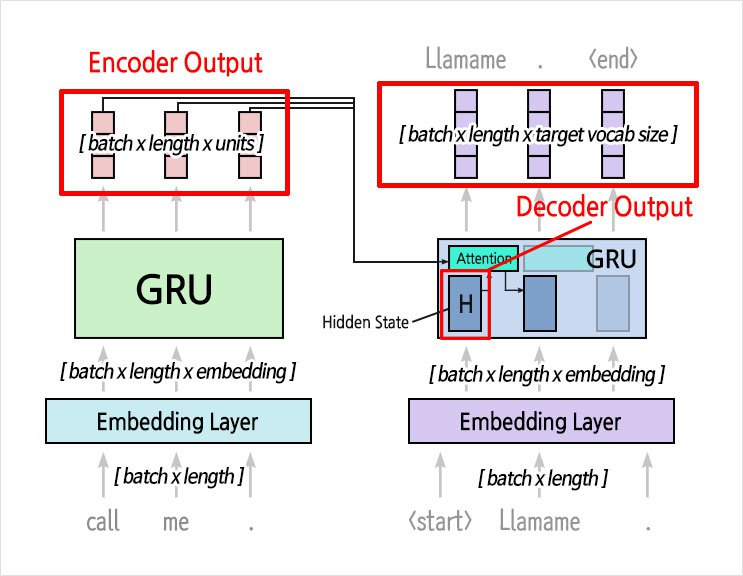

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)   
        # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [20]:
# 하이퍼파라미터 설정
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

# 인코더/디코더 객체 생성
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# 데이터 입/출력 방법 설정
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 30, 1024)
Decoder Output: (32, 1210)
Decoder Hidden State: (32, 1024)
Attention: (32, 30, 1)


# 4. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

#### [예문] 
K1) 오바마는 대통령이다.  
K2) 시민들은 도시 속에 산다.  
K3) 커피는 필요 없다.  
K4) 일곱 명의 사망자가 발생했다.  

#### [제출] 
E1) obama is the president . \<end>  
E2) people are victims of the city . \<end>  
E2) the price is not enough . \<end>  
E2) seven people have died . \<end>  

## (1) Optimizer & Loss

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)   # 패딩을 위한 토큰 명시
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


 Loss 함수

## (2) train_step 구현하기
train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수입니다. 먼저 구성을 보시죠!

In [22]:
@tf.function   # 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줌
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    # 학습하며 발생한 모든 연산을 기록하는 테이프로
    # 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됨
    with tf.GradientTape() as tape:
        enc_out = encoder(src)  # encoder에 소스문장을 전달하여 컨텍스트 벡터인 enc_out을 생성
        h_dec = enc_out[:, -1]  # encoder의 마지막을 가져와 (encoder의 final state) 
                                # decoder의 hidden state로 정의 (t=0일때)
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)
        # Decoder에 입력으로 전달할 <start> 토큰 문장 생성

        for t in range(1, tgt.shape[1]):
            # pred : <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            # 예측된 단어와 정답 간의 Loss를 구한 후, 
            # t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X) -> 그 후 반복!
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


@tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다. 첫 번째 Epoch이 다른 Epoch보다 약간의 시간이 더 걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문이죠! 실제로 위 예제에서 @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간이 소요된답니다! 그러니 가능하다면 사용하는 쪽이 유리하겠죠?

tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프입니다. 이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됩니다. 이 또한 공식 문서를 첨부해드릴게요!

train_step()의 학습 과정은 아래와 같습니다.

1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
3. Decoder에 입력으로 전달할 \<start> 토큰 문장 생성
4. \<start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 반복!

## (3) 훈련하기

In [23]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [24]:
EPOCHS = 30
BATCH_SIZE = 16

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s, Loss 0.0733]


### 성능평가 및 Attention Map 시각화

In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])  # .split()
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))



Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: body was perfect . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


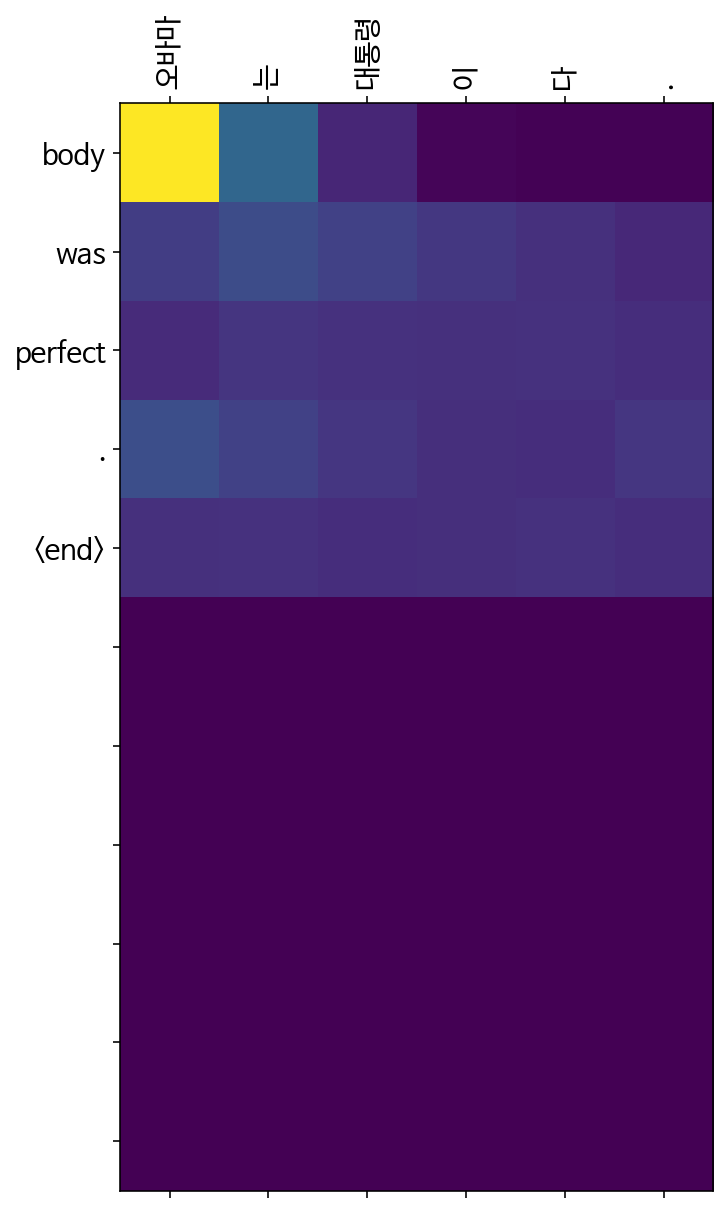

In [26]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they add <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


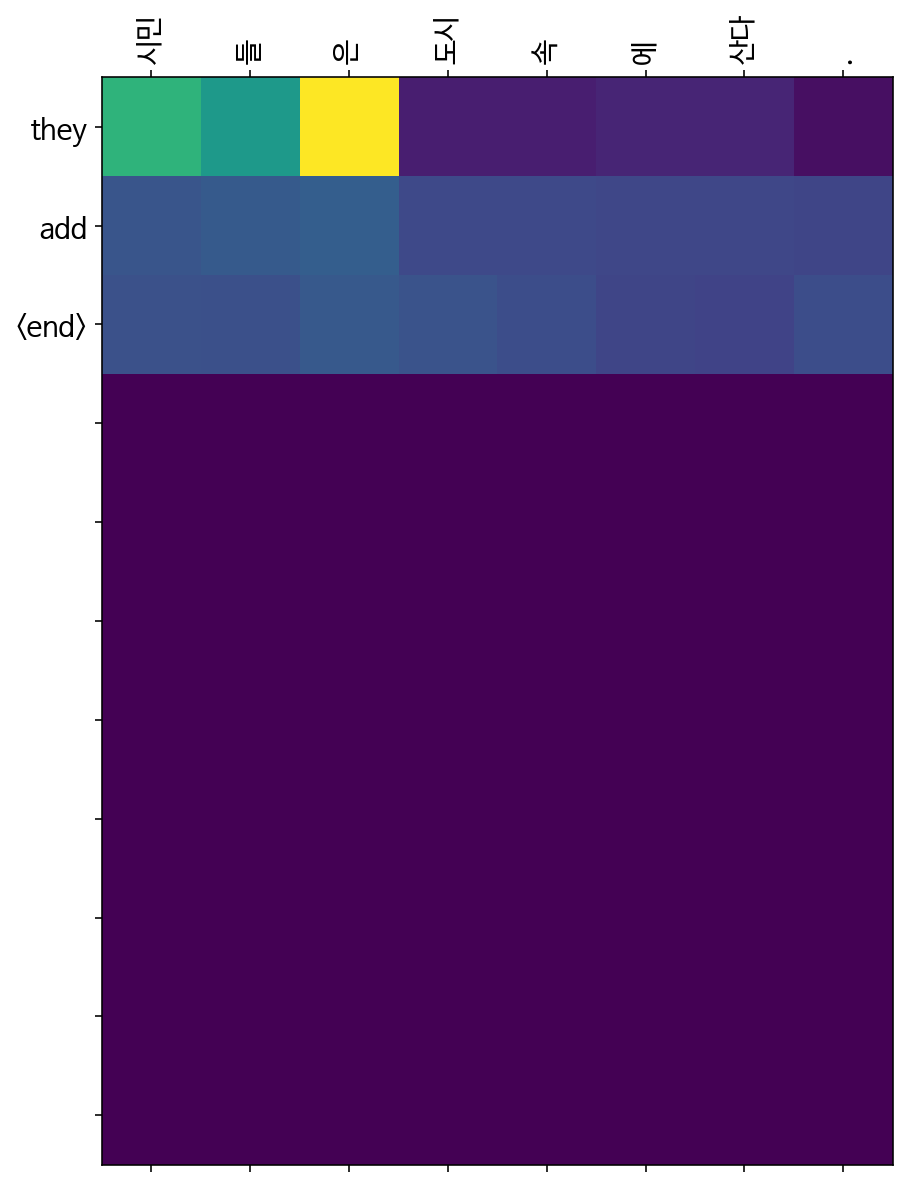

In [27]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: turkey for a minute <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


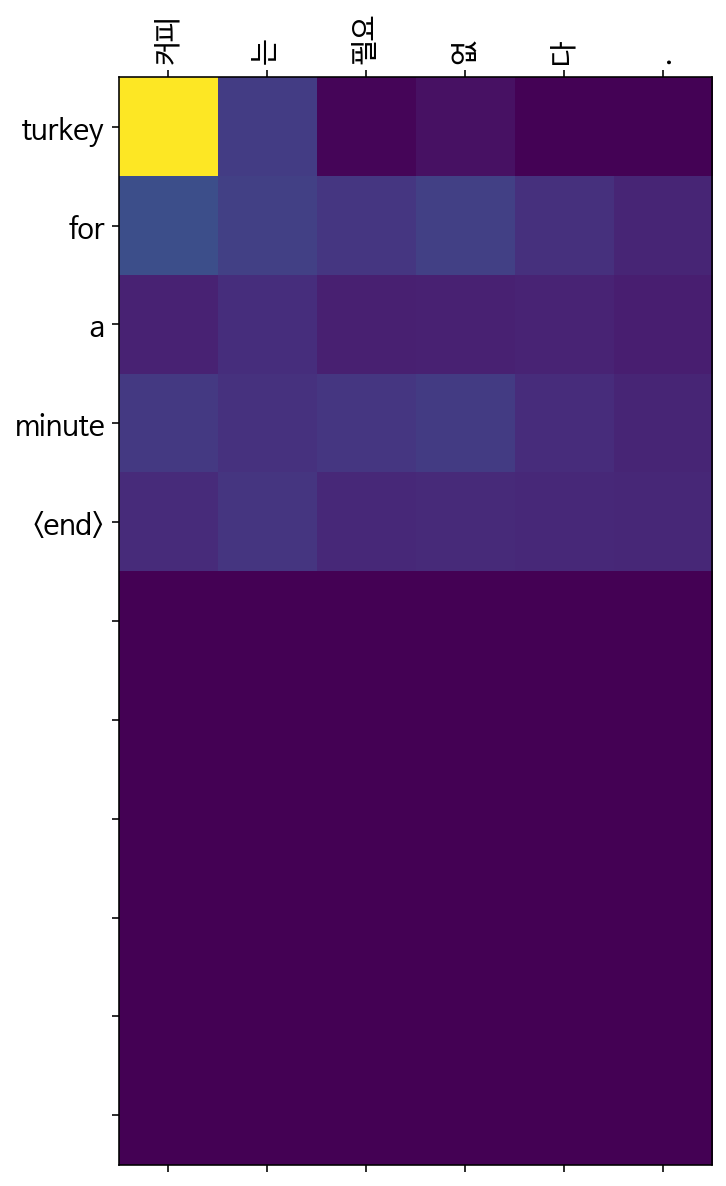

In [28]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: i m . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


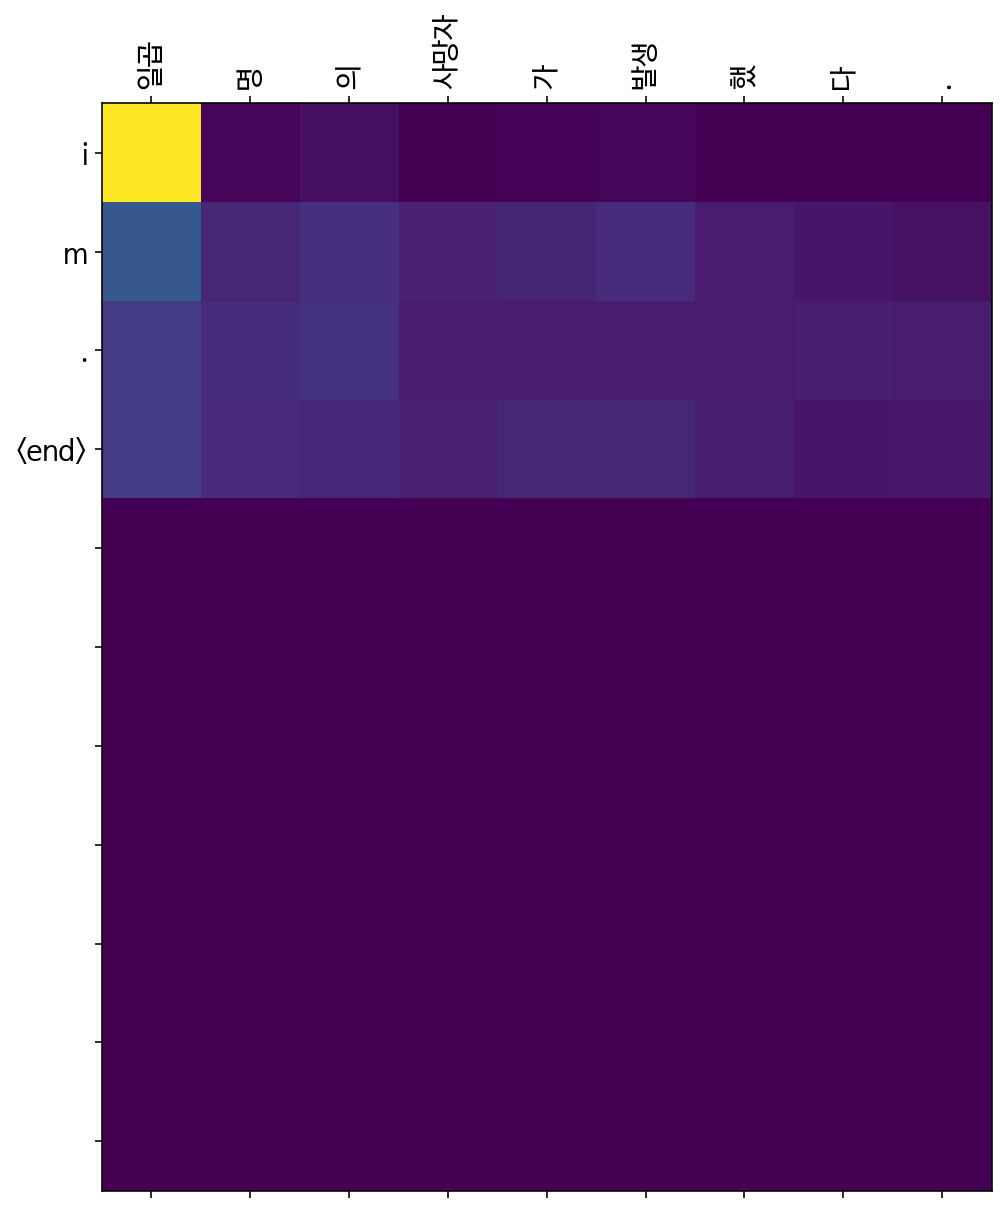

In [29]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

# Ⅳ. 결론

## 1. 결과 분석
- 토큰 길이를 40이하로 제한을 하여 문장 수를 줄일려고 하였다. 그런데 터무니없게도 796개 문장만 남았다. 너무 적어 학습하는데 어려움이 있을 것으로 예상하였다. 일단 코드 전체를 점검하는 차원에서 계속 진행하였다. 그런데 최종 번역한 결과를 보니 예상했던 것처럼 번역이 제대로 되지 않았다. 
- 토큰 길이를 50으로 조정하여 실행 했더니 2273개의 문장이 남았지만 학습과정을 실행하였더니 리소스 고갈 에러가 발생하였다.

## 2. 회고 및 차후 과제

- 형편없는 결과가 나와 아쉬움이 많다.
- 컨텐츠를 새로 생성된 경우에 매번 mecab를 새로 설치해야 했다.
- mecab외의 다른 형태소를 이용해 BoW를 만들고 이후 작업을 진행할 경우 어떨지??